# MATEMATIČKI SOFTVER, ZADAĆA 1. 
# OPTIMIZACIJA PORTFELJA 
Portfelj je skup dionica, obveznica ili bilo kakvih financijskih instrumenata koji imaju neku vrijednost. Cilj ove zadaće je proučiti neke metode optimizacije portfelja za **unaprijed fiksiran** portfelj, primjeniti ih na period od 2012. do 2016. te proučiti njihove rezultate u 2017. godine do danas. Dodatno uspoređujemo njihove prinose ih s tzv. *benchmarkom* najpopularnijim dioničkim indeksom S&P 500. 

Cilj nam je otkriti koja je metoda najefikasnija bila u 2017. te "pobijediti" S&P 500. Na kraju ćemo za jednu metodu usporediti rezultate optimizacije ako prinose gledamo na mjesečnoj i godišnjoj razini.
Prvo učitavamo podatke s Yahoo Finance-a, te ih pripremamo za optimizacije računajući prinose i ostale parametre.
Nadalje, računamo udjele instrumenata u našem portfelju za više metoda.
U idućoj fazi uspoređujemo performansu naših portfelja s naglaskom na vizualizaciju.

Naš portfelj će činiti sljedeći objekti:
* Amazon (AMZN)
* Bitcoin (BTC)
* The Coca-Cola Company (KO)
* JPMorgan Chase & Co (JPM)
* Boeing Company (BA) 
* Visa Inc (V) 
* Johnson&Johnson (JNJ)



## Učitavanje i priprema podataka

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
 
def ucitaj(x):
    y="%s.csv"%x
    z=pd.read_csv(y)
    del z['High'],z['Low'],z['Close'],z['Adj Close'],z['Volume']
    z.drop(0, inplace=True)
    z.rename(columns={'Open':'Price'},inplace=True)
    return z

In [48]:
import numpy as np

def povrat(x):
    y=np.linspace(0,0,59)
    for i in range(1,60):
        y[i-1]=(x['Price'][i+1]-x['Price'][i])/(x['Price'][i])*100
    return y

In [49]:
port=['AMZN','BTC','KO','JPM','BA','V','JNJ']
z={p : povrat(ucitaj(p)) for p in port}

## Provođenje metoda

### Portfelj 1: Equal Weight 
Najjednostavnija vrsta je da od svih 7 uzmemo jednak udio svakog instrumenata u našem portfelju i da to bude naša strategija za 2017. godinu.

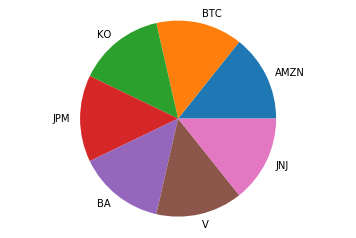

In [4]:
w1=np.linspace(1/7,1/7,7)
labels= 'AMZN','BTC','KO','JPM','BA','V','JNJ'
fig1, ax1 = plt.subplots()
ax1.pie(w1, labels=labels)
ax1.axis('equal') 
plt.show()

### Portfelj 2: Minimum Variance
Strategija se temelji na optimizaciji udjela instrumenata tako da se maksimizira povrat (uz postavljenu donju granicu povrata) pritom minimizirajuci rizik tj varijancu. 
Za donji povrat uzimamo 10% na godišnjoj razini (želimo pobijediti S&P 500, a njen godišnji povrat kroz povijest je oko 8%, ali mi smo spremni na veci rizik). Posto gledamo podatke na mjesecnoj razini donju granicu treba prilagoditi.

Drugim rjecima: _FORMULE_

Za to ce nam biti potreban paket *cvxopt* (potrebno ga je dodatno skinuti i instalirati sto zna biti dugotrajno: 
http://cvxopt.org/download/index.html)

In [5]:
rg=0.10
r=((1+rg)**(1/12)-1)*100
n=7

In [204]:
from statsmodels.stats.correlation_tools import cov_nearest
from cvxopt import matrix,solvers

data=[(povrat(ucitaj(p))) for p in port]
cv=cov_nearest(np.cov(data))
P=matrix(np.cov(data))

In [7]:
ravg=[z[p].mean() for p in port]
ravg=matrix(ravg)

In [8]:
G= matrix(np.concatenate((-np.transpose(np.array(ravg)), -np.identity(n)), 0))
h = matrix(np.concatenate((-np.ones((1,1))*r, np.zeros((n,1))), 0))
q = matrix(np.zeros((n, 1)))

In [9]:
A = matrix(1.0, (1,n))
b=matrix(1.0)
solvers.options['show_progress']=False
solvers.options['maxiters']=100
w2=solvers.qp(P, q, G, h, A, b)
for i in range(0,7):
    print(w2['x'][i])

4.658343623080852e-10
2.807932963519591e-09
0.33477590305471067
0.05599024674355051
0.03222306245594534
0.18825227560635535
0.3887585088656708


In [10]:
w2=[4.65834336382758e-08,2.8079320074491786e-07,0.33477583209897793,
    0.055989989760665555,0.032222948677874896,0.1882526450407398,0.3887582570451074]

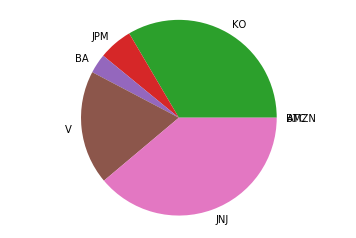

In [11]:
fig2, ax2 = plt.subplots()
ax2.pie(w2, labels=labels)
ax2.axis('equal') 
plt.show()

### Porfelj 2a: Minimum Variance, Risk Ehanced
Zelimo preuzeti dosta veci rizik, stoga granicu godisnjeg povrata povecavamo na 20%.

In [12]:
rg=0.20
r=((1+rg)**(1/12)-1)*100
h = matrix(np.concatenate((-np.ones((1,1))*r, np.zeros((n,1))), 0))
w2a=solvers.qp(P, q, G, h, A, b)
for i in range(0,7):
    print(w2a['x'][i])

0.04231601769582674
0.00461322702416489
0.019035616313593195
0.045654965471400306
0.026494245584335437
0.36328494488685775
0.49860098302382166


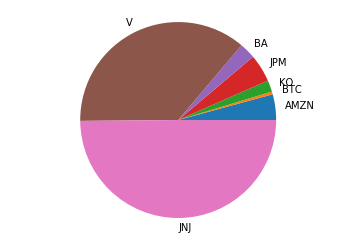

In [13]:
w2a=[0.04231601769582674,0.00461322702416489,0.019035616313593195,0.045654965471400306,
0.026494245584335437,0.36328494488685775,0.49860098302382166]
fig2a, ax2a = plt.subplots()
ax2a.pie(w2a, labels=labels)
ax2a.axis('equal') 
plt.show()


### Portfelj 3: Maximum Diversification
Maximum Diversification Approach je metoda bazirana na riziku koja ne uzima u obzir **ocekivani povrat**.

Temelji se na maksizimizaciji tzv *Diversification ratio*-a:

*FORMULA*

Napomena: problem trazenja maksimuma svodimo na problem trazenja minimuma tako da trazimo minimum izraza 
*1/(diversification_ratio*)

In [14]:
w3=np.linspace(1/7,1/7,7)
def div_ratio(w,V):
    d1=np.dot(np.transpose(w),np.diagonal(V))
    d2=np.sqrt(np.matmul(np.transpose(w),np.matmul(V,w)))
    return d2/d1   

def long_cons(x):
    return min([x[i]>=0 and x[i]<=1 for i in range(0,7)]) and round(sum(x))==1

long_cons(w3)   

True

In [15]:
import scipy as sp
cons = ({'type': 'eq', 'fun': long_cons})
w3=sp.optimize.minimize(div_ratio, w3,args=cv,method='SLSQP')
w3

     fun: 0.014735191294285738
     jac: array([ -1.42588979e-05,   5.20260073e-06,   1.25622610e-05,
         8.09249468e-06,   1.52442371e-05,  -1.87671976e-05,
         2.51421006e-05])
 message: 'Optimization terminated successfully.'
    nfev: 154
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([-1.03784901,  4.44991374, -0.5343624 , -0.93039196, -0.99557013,
       -0.40939187, -0.69435185])

Naisao sam na problem s optimizacijom u scipy-ju (*'Singular matrix C in LSQ subproblem'*) kad postavim ogranicenja za udjele u portfelju (naredba: *w3=sp.optimize.minimize(div_ratio, w3,args=cv,method='SLSQP',constraints=cons)*, primjerice: razuman je uvjet da su nam vrijednosti udjela izmedu 0 i 1, te da u sumi daju 1. 

Zato sam proveo optimizaciju bez *constraints-a* i dobio gornje rezultate. Ako prihvatimo koncpet *sell-short-a*. Vidimo da bi imali samo samo jednu tzv. *long* poziciju, stoga sav novac od "shortanja" mozemo staviti u tu jednu poziciju.

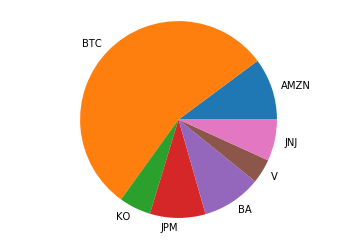

In [16]:
w3=np.array([-1.03784901,  4.44991374, -0.5343624 , -0.93039196, -0.99557013,
       -0.40939187, -0.69435185])
i=1-sum(w3)
w3=np.array([-1.03784901,  4.44991374+i, -0.5343624 , -0.93039196, -0.99557013,
       -0.40939187, -0.69435185])

fig3, ax3 = plt.subplots()
ax3.pie(np.absolute(w3)/(sum(np.absolute(w3))), labels=labels)
ax3.axis('equal') 
plt.show()


## Testiranje rezultata 

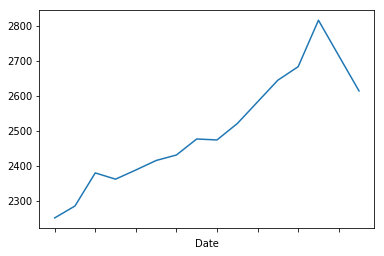

In [17]:
SP=ucitaj("SP2017")
SP.set_index("Date")["Price"].plot()

In [288]:
port2=['AMZNn','BTCn','KOn','JPMn','BAn','Vn','JNJn']
ret=np.linspace(0,0,7)
i=0
for p in port2:
    pov=ucitaj(p)["Price"]
    ret[i]=(pov[15]-pov[1])/pov[1]
    i=i+1
rSP=(SP["Price"][16]-SP["Price"][1])/SP["Price"][1]
r1=np.dot(ret,w1)
r2=np.dot(ret,w2)
r2a=np.dot(ret,w2a)
r3=np.dot(ret,w3)

In [289]:
r=[rSP,r1,r2,r2a,r3]
ret

array([  9.97044556e-01,   9.72727312e+00,  -8.55489017e-03,
         7.20702916e-03,   1.31817006e+00,   5.65007604e-01,
         1.15132165e-01])

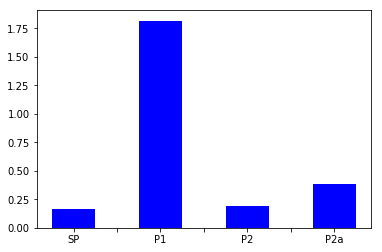

In [185]:
fig5, ax5 = plt.subplots()
ind = np.arange(4)
width=0.5
rects1 = ax5.bar(ind,r[0:4], width, color='b')
ax5.set_xticklabels((' ','SP',' ', 'P1',' ', 'P2',' ', 'P2a'))
plt.show()

Vidimo da su svi nasi portfelji "pobjedili" nas benchmark. Portfelj P3 je nadmasio sve portfelje i to znacajno (toliko da ih  se ne isplati prikazati ostale na istom grafu s njim). Medutim, velika izlozenost bitcoinu nije rizik koju bi prosjecan covjek prihvatio.

S druge strane, P1 je znacajno pobjedio preostale portfelje. To mozda predstavlja prikladan nacin za ulaganje za covjeka koji nema vremena raditi analize trzista i poduzeca. 

Portfelj P2a je odradio takoder odlican rezultat s obzirom na benchmark, ali uz pristojno vecu dozu rizika.

## Dodatak
Kao sto je najavljeno provodimo 2. metodu, ali na godisnjoj bazi umjesto na mjesecnoj kako bi vidjeli koja ce vremenski period dati bolji rezultat. Pitanje na koje zelimo odgovoriti jesu si podaci na godisnjoj bazi dovoljno dobri da bi nas portfelj polucio zadovoljavajuce rezultate?

In [210]:
def ucitaj_godine(x):
    z=ucitaj(x)
    z=[np.array(z["Price"])[p] for p in range(0,61,12)]
    return z
def povrat_g(x):
    y=np.linspace(0,0,5)
    for i in range(0,5):
        y[i-1]=(x[i+1]-x[i])/(x[i])*100
    return y

In [211]:
data2=[(povrat_g(ucitaj_godine(p))) for p in port]
cv2=cov_nearest(np.cov(data2))
P=matrix(np.cov(data2))

In [284]:
ravg=[povrat_g(ucitaj_godine(p)).mean() for p in port]
ravg=matrix(ravg)
rg=0.10
r=((1+rg)**(1/12)-1)*100
G= matrix(np.concatenate((-np.transpose(np.array(ravg)), -np.identity(n)), 0))
h = matrix(np.concatenate((-np.ones((1,1))*r, np.zeros((n,1))), 0))
q = matrix(np.zeros((n, 1)))
solvers.options['show_progress']=False
w4=solvers.qp(P, q, G, h, A, b)

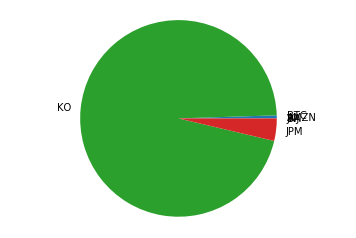

In [285]:
w4=np.array(w4['x'])
fig4, ax4 = plt.subplots()
ax4.pie(w4, labels=labels)
ax4.axis('equal') 
plt.show()

<BarContainer object of 2 artists>

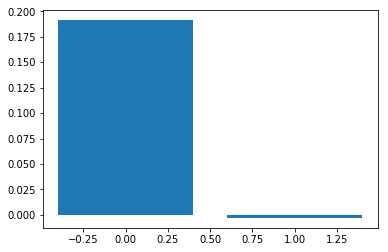

In [286]:
r4=np.dot(ret,w4)
x=range(2)
y=np.array([r2,r4])
plt.bar(x,y)

In [287]:
r4

array([-0.0029123])

Vidimo da nam se strategija s manje podataka ne isplati, te da bi polucila cak gubitke i to u godini kad su svi nasi portfelji ostvarili i iznadprosjecne dobitke. 

Napomenimo da sam u zadaci motrio **iskljucivo performansu** portfelja, ne ukljucujuci **troskove transakcija** koji mogu biti i vise nego nezanemarivi.

## Zakljucak

In [201]:
def mj_pov(pov):
    ret=np.linspace(0,0,16)
    ret[0]=1
    for i in range(0,15):
        ret[i+1]=(1+(pov[i+1]-pov[i])/pov[i])*ret[i]
    return ret
pov=np.array(ucitaj("SP2017")["Price"])
rSP=mj_pov(pov)

array([ 1.        ,  1.01510947,  1.05709785,  1.04919679,  1.06081531,
        1.07287352,  1.07986419,  1.10016567,  1.09897531,  1.11975194,
        1.14729273,  1.17478027,  1.19193714,  1.25088266,  1.20592293,
        1.1611497 ,  1.        ,  1.01510947,  1.05709785,  1.04919679,
        1.06081531,  1.07287352,  1.07986419,  1.10016567,  1.09897531,
        1.11975194,  1.14729273,  1.17478027,  1.19193714,  1.25088266,
        1.20592293,  1.1611497 ])

In [85]:
(pov2-pov)/pov

array([  0.51788056,  18.70974555,   0.15153237,   0.3960657 ,
         0.14591702,   0.64168279,   0.24089044])

In [83]:
port2=['AMZNn','BTCn','KOn','JPMn','BAn','Vn','JNJn']
port2

['AMZNn', 'BTCn', 'KOn', 'JPMn', 'BAn', 'Vn', 'JNJn']